In [2]:
import pathlib
%load_ext autoreload
%autoreload 2

In [14]:

from tqdm.notebook import tqdm

import escnn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import default_collate

from escnn.nn import FieldType, GeometricTensor

from NCP.models.equiv_ncp import ENCPOperator
from NCP.cde_fork.density_simulation.symmGMM import SymmGaussianMixture
from NCP.mysc.symm_algebra import symmetric_moments
from NCP.examples.symm_GMM import plot_analytic_joint_2D,plot_analytic_mi_2D

# Example symmetric conditional expectation and density estimation


This toy examples studies the problem of conditional density estimation and conditional expectation in the presence of symmetries in the marginals and in the joint probability distributions


<Figure size 236.22x157.48 with 0 Axes>

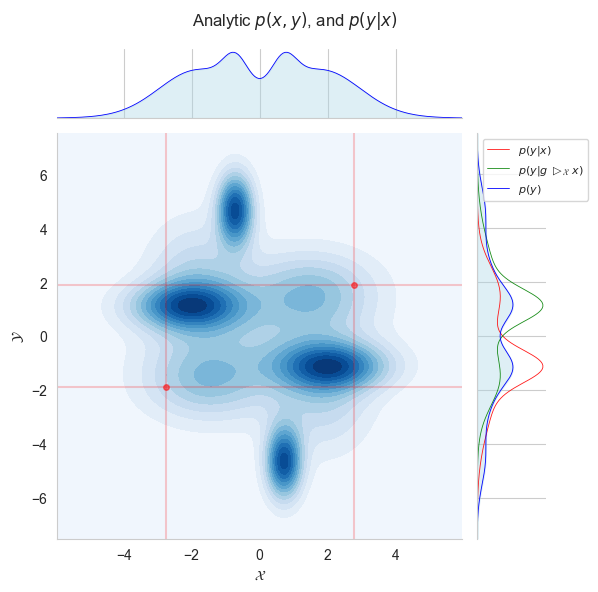

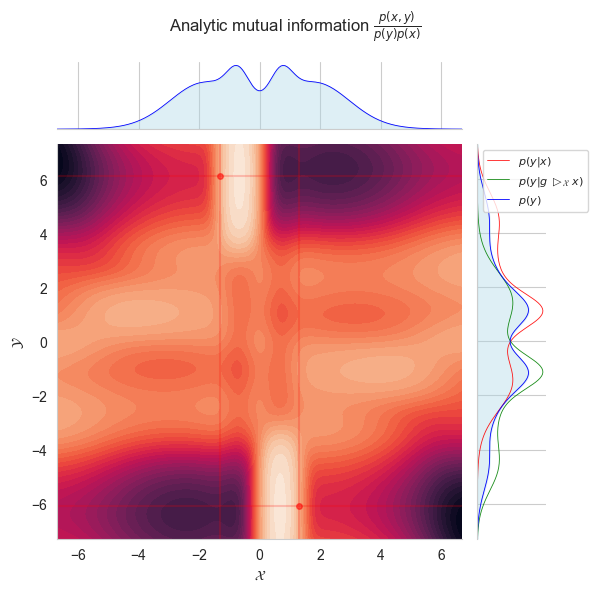

In [24]:
C2 = escnn.group.CyclicGroup(2)        # Reflection group = Cyclic group of order 2
rep_X = C2.representations['irrep_1']                       # ρ_Χ
rep_Y = C2.representations['irrep_1']                       # ρ_Y
rep_X.name, rep_Y.name = "rep_X", "rep_Y"

gmm = SymmGaussianMixture(n_kernels=6, rep_X=rep_X, rep_Y=rep_Y, means_std=2.0, random_seed=7)

# Create a figure with joint 2D and marginal plots
cm2inch = lambda x: x/2.54
fig = plt.figure(figsize=(cm2inch(6), cm2inch(4)))
grid_plot = plot_analytic_joint_2D(gmm, G=C2, rep_X=rep_X, rep_Y=rep_Y)
grid_mi_plot = plot_analytic_mi_2D(gmm, G=C2, rep_X=rep_X, rep_Y=rep_Y)



# Training



(10000,) (10000,)
torch.Size([1]) torch.Size([1])
(7000,) (1500,) (1500,)


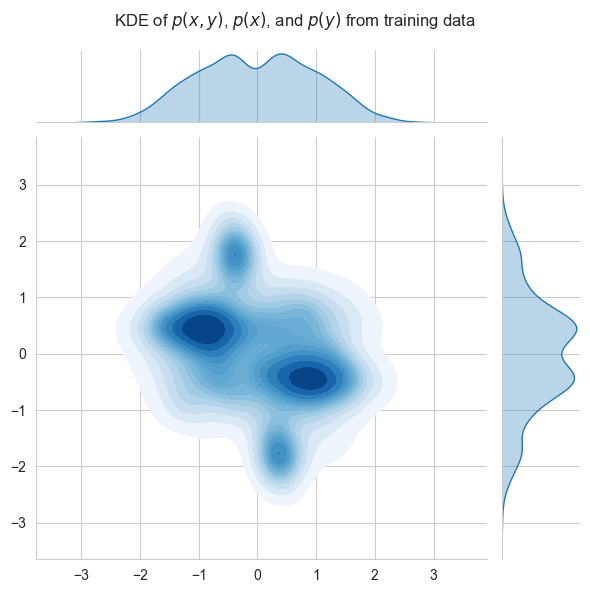

In [25]:
x_samples, y_samples = gmm.simulate(n_samples=10 ** 4)
x_samples = x_samples.squeeze()
y_samples = y_samples.squeeze()
print(x_samples.shape, y_samples.shape)
x_mean, x_var = symmetric_moments(np.expand_dims(x_samples, 1), rep_X)
y_mean, y_var = symmetric_moments(np.expand_dims(y_samples, 1), rep_Y)
print(x_mean.shape, y_mean.shape)

x_mean, x_var, y_mean, y_var

# Train, val, test splitting
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
n_samples = len(x_samples)
n_train, n_val, n_test = np.asarray(np.array([train_ratio, val_ratio, test_ratio]) * n_samples, dtype=int)
X = (x_samples - x_mean.numpy()) / np.sqrt(x_var.numpy())
Y = (y_samples - y_mean.numpy()) / np.sqrt(y_var.numpy())
x_train, x_val, x_test = X[:n_train], X[n_train:n_train + n_val], X[n_train + n_val:]
y_train, y_val, y_test = Y[:n_train], Y[n_train:n_train + n_val], Y[n_train + n_val:]
print(x_train.shape, x_val.shape, x_test.shape)
# Joint KDE plot
grid = sns.JointGrid()
sns.kdeplot(x=np.squeeze(x_train), y=np.squeeze(y_train), fill=True, ax=grid.ax_joint, cmap="Blues", levels=15)
sns.kdeplot(x=np.squeeze(x_train), ax=grid.ax_marg_x, fill=True, alpha=0.3, label=r"$p(x)$")
sns.kdeplot(y=np.squeeze(y_train), ax=grid.ax_marg_y, fill=True, alpha=0.3, label=r"$p(y)$")
grid.fig.suptitle(r"KDE of $p(x,y)$, $p(x)$, and $p(y)$ from training data")
grid.fig.tight_layout()

In [7]:

from NCP.nn.equiv_layers import EMLP
from NCP.models.ncp_lightning_module import NCPModule
from lightning.pytorch.loggers import WandbLogger
import lightning

lat_dim = 6
batch_size = 1024

# Define the Input and Latent types for ESCNN
x_type = FieldType(gspace=escnn.gspaces.no_base_space(C2), representations=[rep_X])
y_type = FieldType(gspace=escnn.gspaces.no_base_space(C2), representations=[rep_Y])
lat_type = FieldType(
    gspace=escnn.gspaces.no_base_space(C2),
    representations=[C2.regular_representation]* (lat_dim // C2.order())
    )

# ESCNN equivariant models expect GeometricTensors.
def geom_tensor_collate_fn(batch) -> [GeometricTensor, GeometricTensor]:
    x_batch, y_batch = default_collate(batch)
    return GeometricTensor(x_batch, x_type), GeometricTensor(y_batch, y_type)

X_train = torch.unsqueeze(torch.from_numpy(x_train).float(), 1)
Y_train = torch.unsqueeze(torch.from_numpy(y_train).float(), 1)
X_val = torch.unsqueeze(torch.from_numpy(x_val).float(), 1)
Y_val = torch.unsqueeze(torch.from_numpy(y_val).float(), 1)
X_test = torch.unsqueeze(torch.from_numpy(x_test).float(), 1)
Y_test = torch.unsqueeze(torch.from_numpy(y_test).float(), 1)

train_dataset = TensorDataset(X_train, Y_train)
val_dataset = TensorDataset(X_val, Y_val)
test_dataset = TensorDataset(X_test, Y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=geom_tensor_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=geom_tensor_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=geom_tensor_collate_fn)

cfg = dict(hidden_units=64, hidden_layers=3, gamma=0.1, irreps=rep_X.irreps + rep_Y.irreps, embedding_dim=lat_type.size, lr=1e-4)

print(lat_type.size)
χ_embedding = EMLP(in_type=x_type, out_type=lat_type, hidden_layers=cfg['hidden_layers'], hidden_units=cfg['hidden_units'], bias=False)
y_embedding = EMLP(in_type=y_type, out_type=lat_type, hidden_layers=cfg['hidden_layers'], hidden_units=cfg['hidden_units'], bias=False)
eNCPop = ENCPOperator(χ_embedding, y_embedding, gamma=cfg["gamma"])

# print(eNCPop)
lightning_module = NCPModule(
    model=eNCPop,
    optimizer_fn=torch.optim.Adam,
    optimizer_kwargs={"lr": cfg["lr"]},
    loss_fn=eNCPop.loss,
    )

pathlib.Path("lightning_logs").mkdir(exist_ok=True)
logger = WandbLogger(save_dir="lightning_logs", project="NCP-GMM-C2", log_model=False, config=cfg)
logger.watch(lightning_module, log="all", log_graph=False)
trainer = lightning.Trainer(max_epochs=500, logger=logger, enable_progress_bar=False, log_every_n_steps=4, check_val_every_n_epoch=5)

torch.set_float32_matmul_precision('medium')
trainer.fit(lightning_module, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

a = trainer.test(lightning_module, dataloaders=test_dataloader)

6


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: danfoa (dls-csml). Use `wandb login --relogin` to force relogin


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
